In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import stats
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
sns.set(style="whitegrid", color_codes=True)
plt.rcParams['figure.figsize'] = (12, 12)

In [151]:
def preprocess_spectra(df):
    df = average_dataframe(df, 15).transpose()
    nm = [str(int(x)) for x in df.iloc[0]]
    df = df.drop("Wavelengths", 0)
    df.columns = nm
    df = pd.concat([base, df], axis=1)
    return df

def average_dataframe(df, n):
    # Separate label column from data
    label = df.iloc[:,0]
    df = df.iloc[:,1:]

    if (df.shape[1]) % n != 0:
        raise Exception("Number of columns: {}. Not divisible by {}.".format(df.shape[1], n))

    # Average every N columns
    average_df = pd.DataFrame()
    average_df["Wavelengths"] = label
    for i in range((df.shape[1]) // n):
        average_df[i] = df.iloc[:,i*n:(i+1)*n].mean(axis=1)

    return average_df

In [152]:
gt_10_20 = pd.read_csv("../data/Spreadsheet/Lettuce/2017-10-20.csv").dropna().drop("Plant Number", 1)
gt_10_27 = pd.read_csv("../data/Spreadsheet/Lettuce/2017-10-27.csv").dropna().drop("Plant Number", 1)
gt_11_03 = pd.read_csv("../data/Spreadsheet/Lettuce/2017-11-03.csv").dropna().drop("Plant Number", 1)
gt_11_10 = pd.read_csv("../data/Spreadsheet/Lettuce/2017-11-10.csv").dropna().drop("Plant Number", 1)
gt_11_17 = pd.read_csv("../data/Spreadsheet/Lettuce/2017-11-17.csv").dropna().drop("Plant Number", 1)
gt_11_22 = pd.read_csv("../data/Spreadsheet/Lettuce/2017-11-22.csv").dropna().drop("Plant Number", 1)
base = pd.read_csv("../data/Spreadsheet/Lettuce/base.csv")

In [153]:
gt_10_20.head()

,Nitrogen,Irrigation,Replication,Chlorophyll,NDVI,WP
0,0,0,1,42.1,0.750192,-4.85
2,0,0,2,32.5,0.767223,-4.31
4,0,0,3,50.5,0.788855,-4.91
6,0,25,1,46.9,0.809253,-1.30
8,0,25,2,48.6,0.817409,-1.32


In [154]:
# Drop every 2nd to match water potential
spectra_10_20 = preprocess_spectra(pd.read_csv("../data/Unprocessed/2017-10-20.csv")).iloc[::2]
spectra_10_27 = preprocess_spectra(pd.read_csv("../data/Unprocessed/2017-10-27.csv")).iloc[::2]
spectra_11_03 = preprocess_spectra(pd.read_csv("../data/Unprocessed/2017-11-03.csv")).iloc[::2]
spectra_11_10 = preprocess_spectra(pd.read_csv("../data/Unprocessed/2017-11-10.csv")).iloc[::2]
spectra_11_17 = preprocess_spectra(pd.read_csv("../data/Unprocessed/2017-11-17.csv")).iloc[::2]
spectra_11_22 = preprocess_spectra(pd.read_csv("../data/Unprocessed/2017-11-22.csv")).iloc[::2]

In [155]:
spectra_10_20.head()

,Nitrogen,Irrigation,Replication,325,326,327,328,329,330,331,...,1066,1067,1068,1069,1070,1071,1072,1073,1074,1075
0,100,100,1,0.376673,0.431226,0.390331,0.378475,0.414101,0.375501,0.341410,...,0.817662,0.815959,0.810296,0.802925,0.812756,0.822892,0.815623,0.813108,0.815696,0.818738
2,25,100,2,0.340363,0.380392,0.337493,0.327786,0.367546,0.336059,0.310546,...,0.753317,0.750848,0.747314,0.744372,0.753046,0.760608,0.753906,0.749332,0.748282,0.748953
4,0,100,3,0.403479,0.429305,0.350453,0.333168,0.402504,0.381900,0.358693,...,0.860377,0.855473,0.850105,0.847901,0.858569,0.866247,0.855605,0.852129,0.856937,0.865607
6,100,25,1,0.412089,0.474489,0.434818,0.417667,0.441788,0.381190,0.333433,...,0.781725,0.775529,0.768707,0.766347,0.774526,0.781899,0.777127,0.777329,0.780802,0.780962
8,25,25,2,0.361481,0.419213,0.351152,0.337465,0.402751,0.360939,0.318642,...,0.748609,0.741339,0.736409,0.739257,0.748861,0.754771,0.747235,0.743047,0.743995,0.748644


In [156]:
df_10_20 = pd.merge(gt_10_20, spectra_10_20, on=["Nitrogen", "Irrigation", "Replication"])
df_10_27 = pd.merge(gt_10_27, spectra_10_27, on=["Nitrogen", "Irrigation", "Replication"])
df_11_03 = pd.merge(gt_11_03, spectra_11_03, on=["Nitrogen", "Irrigation", "Replication"])
df_11_10 = pd.merge(gt_11_10, spectra_11_10, on=["Nitrogen", "Irrigation", "Replication"])
df_11_17 = pd.merge(gt_11_17, spectra_11_17, on=["Nitrogen", "Irrigation", "Replication"])
df_11_22 = pd.merge(gt_11_22, spectra_11_22, on=["Nitrogen", "Irrigation", "Replication"])

In [157]:
df = pd.concat([df_10_20, df_10_27, df_11_03, df_11_10, df_11_17, df_11_22])

In [158]:
df.shape

(288, 757)

# Train Predictor

In [159]:
df.iloc[:, 6:].head()

,325,326,327,328,329,330,331,332,333,334,...,1066,1067,1068,1069,1070,1071,1072,1073,1074,1075
0,0.222486,0.292445,0.375240,0.348562,0.247189,0.233466,0.245784,0.224207,0.210134,0.204702,...,0.659310,0.669386,0.680358,0.680175,0.670612,0.661400,0.661356,0.664555,0.665840,0.659393
1,0.350766,0.320070,0.361682,0.349854,0.280499,0.233168,0.226500,0.267084,0.318308,0.346988,...,0.810852,0.818034,0.817178,0.803634,0.811003,0.818421,0.804866,0.802859,0.808636,0.808162
2,0.233017,0.277779,0.362633,0.344437,0.252333,0.317711,0.386864,0.321211,0.245216,0.195074,...,0.659605,0.661009,0.660257,0.658134,0.652643,0.648347,0.649743,0.653122,0.654694,0.650221
3,0.254693,0.327870,0.357548,0.327437,0.259101,0.232353,0.228960,0.231031,0.218726,0.202214,...,0.759934,0.766243,0.775830,0.778986,0.773825,0.767981,0.768517,0.768115,0.766091,0.763255
4,0.288307,0.297616,0.275639,0.246626,0.226985,0.222543,0.246452,0.302393,0.285828,0.230713,...,0.711286,0.711179,0.710186,0.709315,0.713473,0.714361,0.705093,0.706144,0.712340,0.710148


In [160]:
X_train, X_valid, y_train, y_valid = train_test_split(df.iloc[:, 6:], df["WP"], test_size=0.15)

In [163]:
from sklearn.linear_model import LinearRegression, Lasso
reg = LinearRegression()
reg.fit(X_train, y_train)
print(mean_absolute_error(reg.predict(X_train), y_train))
print(mean_absolute_error(reg.predict(X_valid), y_valid))

4.2819527523e-13
2.13368372195


In [164]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(max_iter=500)
mlp.fit(X_train, y_train)
print(mean_absolute_error(mlp.predict(X_train), y_train))
print(mean_absolute_error(mlp.predict(X_valid), y_valid))

1.1555957981
1.12651157656


1.4696715784865375

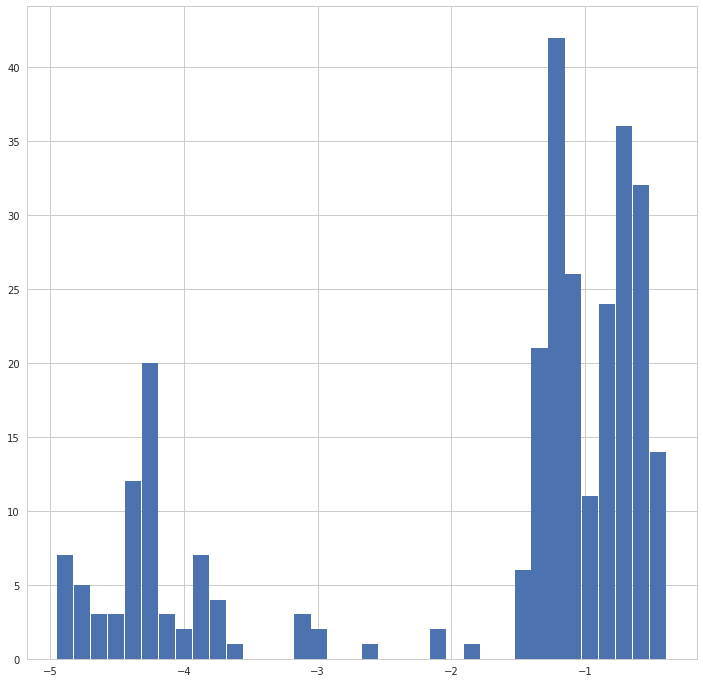

In [165]:
plt.hist(df["WP"], 36, rwidth=0.95)
np.std(df["WP"])

# Testing Various Indices

In [166]:
df["YELLOW1"] = df["550"]
df["RED1"] = df["680"]
df["RED3"] = df["670"]
df["NIR1"] = df["800"]
df["NIR3"] = df["900"]
df["NIR4"] = df["970"]
df["NIR5"] = df["700"]

In [167]:
df["WBI"] = df["NIR3"] / df["NIR4"]
stats.pearsonr(df["WBI"], df["WP"])

(0.020579162097869013, 0.72802196405931585)

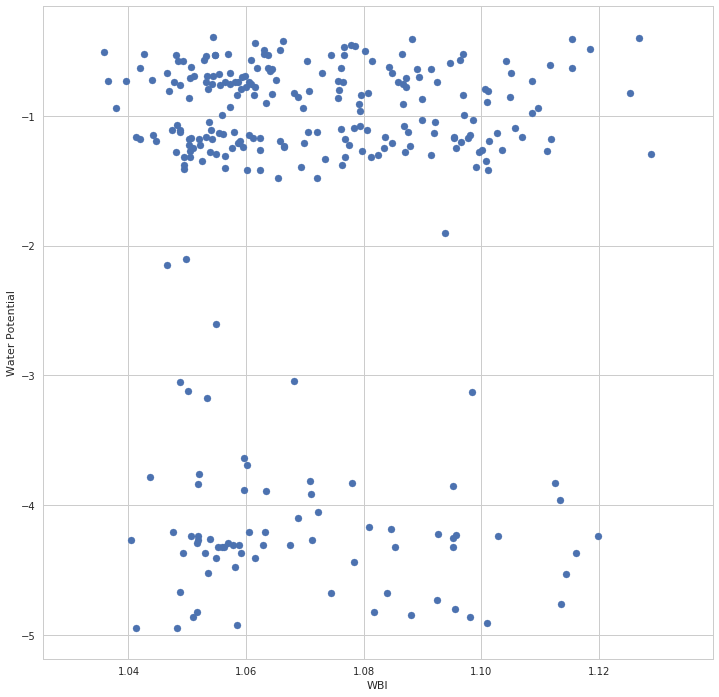

In [168]:
fig = plt.figure
plt.scatter(df["WBI"], df["WP"])
plt.xlabel("WBI")
plt.ylabel("Water Potential")

In [169]:
print(df[df["Irrigation"] == 100]["WBI"].mean())
print(df[df["Irrigation"] == 50]["WBI"].mean())
print(df[df["Irrigation"] == 25]["WBI"].mean())
print(df[df["Irrigation"] == 0]["WBI"].mean())

1.07208801371
1.07101638977
1.07218742384
1.07061766113


In [170]:
print(df[df["Irrigation"] == 100]["NIR4"].mean())
print(df[df["Irrigation"] == 50]["NIR4"].mean())
print(df[df["Irrigation"] == 25]["NIR4"].mean())
print(df[df["Irrigation"] == 0]["NIR4"].mean())

0.772496387676
0.777323044743
0.768190640167
0.766578515669


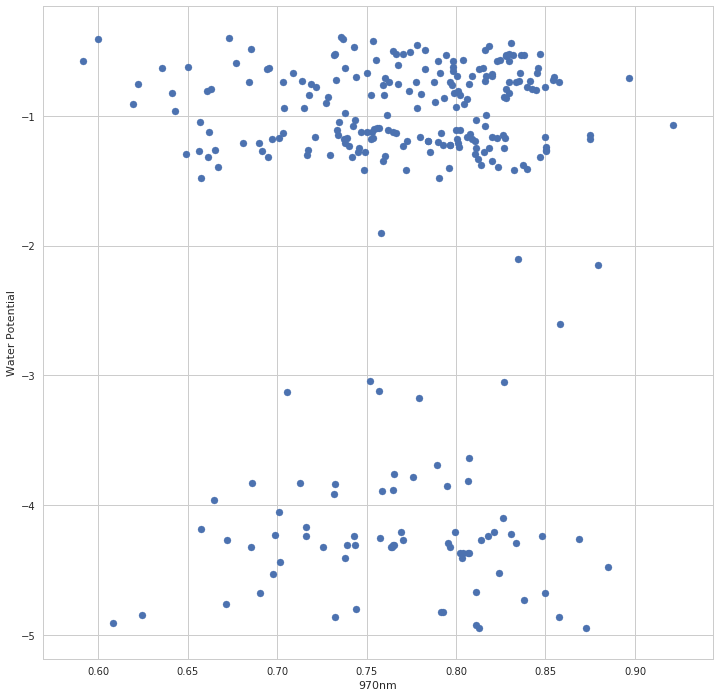

In [172]:
fig = plt.figure
plt.scatter(df["NIR4"].values, df["WP"])
plt.xlabel("970nm")
plt.ylabel("Water Potential")

In [173]:
ndvi = (df["NIR1"] - df["RED1"]) / (df["NIR1"] + df["RED1"])
stats.pearsonr(ndvi, df["Chlorophyll"]), stats.pearsonr(ndvi, df["WP"])

((-0.026482234284780869, 0.6544834705155953),
 (0.021251425615822609, 0.71950474879001847))

In [177]:
df["rededge"] = df["NIR5"] / df["RED3"]
stats.pearsonr(df["rededge"], df["Chlorophyll"]), stats.pearsonr(df["rededge"], df["WP"])

((-0.33544846208971663, 5.2826830059936348e-09),
 (0.19335850449918951, 0.00097267646183192428))

In [178]:
df["MCARI"] = (df["NIR5"] / df["RED3"]) - 0.23 * (df["NIR5"] - df["YELLOW1"]) * df["NIR5"] / df["RED3"]
stats.pearsonr(df["MCARI"], df["Chlorophyll"]), stats.pearsonr(df["MCARI"], df["WP"])

((-0.33289733789649778, 7.0014615046617029e-09),
 (0.19381294312665556, 0.00094565501495717894))

In [180]:
NIR = df["800"]
GREEN = df["550"]
df["GNDVI"] = (NIR - GREEN) / (NIR + GREEN)
stats.pearsonr(df["GNDVI"], df["Chlorophyll"]), stats.pearsonr(df["GNDVI"], df["WP"])

((0.11842637690224482, 0.044633333630659883),
 (-0.11176309785831248, 0.058175501836789746))